In [2]:
import sys
import os
sys.path.append("/home/ehajizad/ss_learning/deepmask-pytorch")
import argparse
import models
import numpy as np
import time
import cv2
from PIL import Image
import torch
from tools.InferDeepMask import Infer
from utils.load_helper import load_pretrain
from matplotlib import pyplot as plt
# %matplotlib widget

| number of paramaters trunk: 15.229 M
| number of paramaters mask branch: 1.609 M
| number of paramaters score branch: 0.526 M
| number of paramaters total: 17.364 M
Segment Proposal Score: 1.000


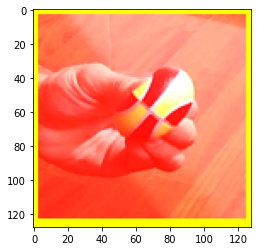

Segment Proposal Score: 0.996


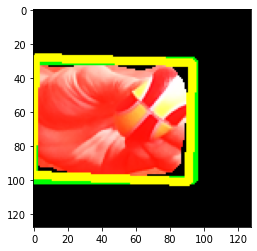

Segment Proposal Score: 0.931


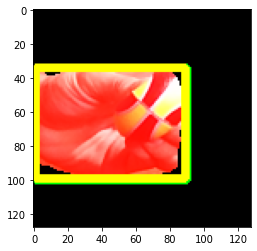

Segment Proposal Score: 0.929


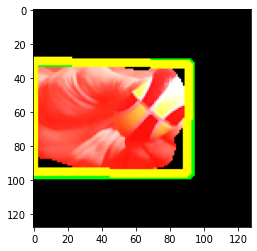

Segment Proposal Score: 0.883


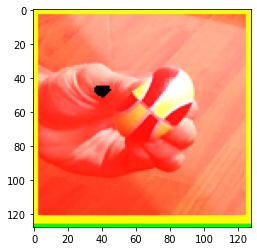

Segment Proposal Score: 0.833


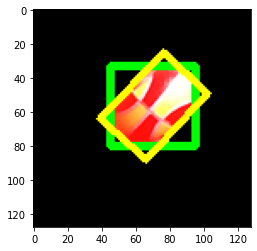

Segment Proposal Score: 0.832


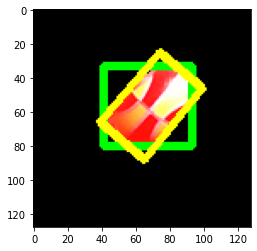

Segment Proposal Score: 0.796


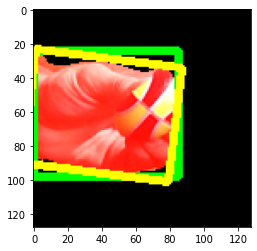

Segment Proposal Score: 0.794


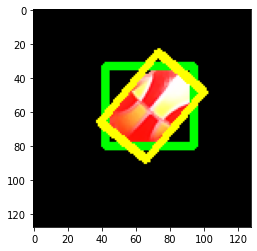

Segment Proposal Score: 0.741


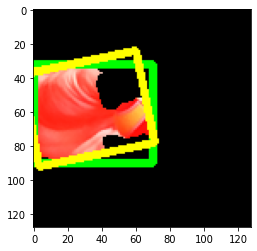

In [10]:
model_names = sorted(name for name in models.__dict__
                     if not name.startswith("__") and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch DeepMask/SharpMask evaluation')
parser.add_argument('--arch', '-a', metavar='ARCH', default='DeepMask', choices=model_names,
                    help='model architecture: ' + ' | '.join(model_names) + ' (default: DeepMask)')
parser.add_argument('--resume', default='exps/deepmask/train/model_best.pth.tar',
                    type=str, metavar='PATH', help='path to checkpoint')
parser.add_argument('--img', default='data/testImage.jpg',
                    help='path/to/test/image')
parser.add_argument('--nps', default=10, type=int,
                    help='number of proposals to save in test')
parser.add_argument('--si', default=-2.5, type=float, help='initial scale')
parser.add_argument('--sf', default=.5, type=float, help='final scale')
parser.add_argument('--ss', default=.5, type=float, help='scale step')


def range_end(start, stop, step=1):
    return np.arange(start, stop+step, step)


def main():
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup Model
    from collections import namedtuple
    Config = namedtuple('Config', ['iSz', 'oSz', 'gSz', 'batch'])
    config = Config(iSz=160, oSz=56, gSz=112, batch=1)  # default for training

    model = (models.__dict__[args.arch](config))
    model = load_pretrain(model, args.resume)
    model = model.eval().to(device)

    scales = [2**i for i in range_end(args.si, args.sf, args.ss)]
    meanstd = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
    infer = Infer(nps=args.nps, scales=scales, meanstd=meanstd, model=model, device=device, timer=False)
    

    

    # print('| start'); tic = time.time()
    im_path = args.img
    im = np.array(Image.open(im_path).convert('RGB'), dtype=np.float32)
    h, w = im.shape[:2]
    img = np.expand_dims(np.transpose(im, (2, 0, 1)), axis=0).astype(np.float32)
    img = torch.from_numpy(img / 255.).to(device)
    infer.forward(img)
    masks, scores = infer.getTopProps(.2, h, w)
    # toc = time.time() - tic
    # print('| done in %05.3f s' % toc)

    for i in range(masks.shape[2]):
        res = im[:,:,::-1].copy().astype(np.uint8)
        res = res*np.expand_dims(masks[:, :, i], axis=2)

        res[:, :, 2] = masks[:, :, i] * 255 + (1 - masks[:, :, i]) * res[:, :, 2]

        mask = masks[:, :, i].astype(np.uint8)
        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt_area = [cv2.contourArea(cnt) for cnt in contours]
        cnt_max_id = np.argmax(cnt_area)
        contour = contours[cnt_max_id]
        polygons = contour.reshape(-1, 2)

        predict_box = cv2.boundingRect(polygons)
        predict_rbox = cv2.minAreaRect(polygons)
        rbox = cv2.boxPoints(predict_rbox)
        print('Segment Proposal Score: {:.3f}'.format(scores[i]))

        res = cv2.rectangle(res, (predict_box[0], predict_box[1]),
                      (predict_box[0]+predict_box[2], predict_box[1]+predict_box[3]), (0, 255, 0), 3)
        res = cv2.polylines(res, [np.int0(rbox)], True, (0, 255, 255), 3)

        res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

        plt.imshow(res)
        plt.show()
    # cv2.imshow('Proposal', res)
    # cv2.waitKey(0)


if __name__ == '__main__':
    global args
    sys.argv = ['', '--arch', 'DeepMask',
                '--resume', '/home/ehajizad/ss_learning/deepmask-pytorch/pretrained/deepmask/DeepMask.pth.tar',
                '--img', '/home/ehajizad/.avalanche/data/core50/core50_128x128/s7/o31/C_07_31_207.png']
    args = parser.parse_args()
    main()